## **NLP Modelling for Integrated Word**

Model NLP ini dibuat dengan tujuan untuk dapat melakukan ektraksi informasi berupa Jumlah Barang, Nama Barang, Motif dan lokasi dari sebuah kalimat. 

Contoh kasus:

`"Saya mau memesan 5 piring dan 4 gelas dengan motif floral"`

Output berupa:

**Jumlah Barang** : `5; 4`

**Nama Barang** : `piring; gelas`

**Motif** : `floral`


### A. Libraries

In [40]:
import pandas as pd
import json
import numpy as np
import tensorflow as tf
import pickle

from IPython.display import display, HTML

from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Dense, TimeDistributed, Bidirectional, LSTM
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import pad_sequences

import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec


### B. Load Dataset

Dataset yang digunakan merupakan dataset fiksional yang dibuat / di-generate oleh ChatGpt. 

In [3]:
with open('augmented_data.json') as f:
    dataset = json.load(f)
df = pd.DataFrame(dataset)

display(HTML('<center><b><h3>Sample Dataset</h3></b></center>'))
df.sample(3)

,input,output
58,Kirimkan 5 piring dan 5 sendok dengan motif po...,"{'Jumlah barang': [5, 5], 'Nama barang': ['pir..."
55,Saya mau memesan 6 cangkir bermotif kotak-kota...,"{'Jumlah barang': [6, 7], 'Nama barang': ['can..."
60,Saya ingin membeli 3 cangkir dengan motif gari...,"{'Jumlah barang': [3], 'Nama barang': ['cangki..."


#### **Penampilan Jumlah Kata dalam dataset**

Jumlah kata dalam dataset akan memberikan gambaran sederhana dari dataset terkait apakah memerlukan padding yang akan mengisi sebagian panjang kata yang pendek atau harus memotong kalimat yang memiliki panjang yang besar. 

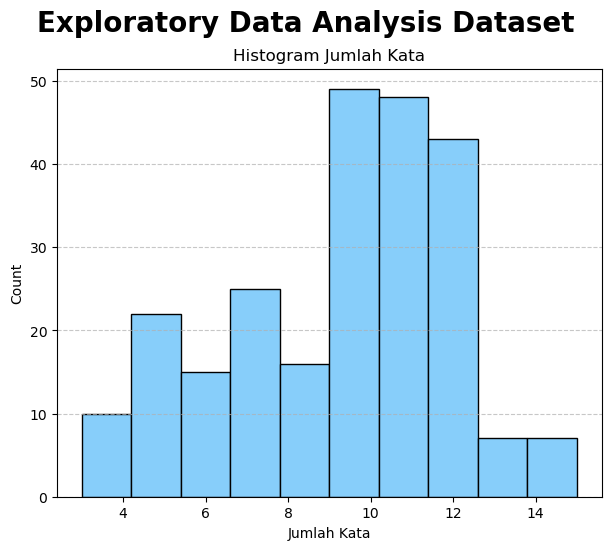

In [4]:
# Melakukan persalinan terhadap dataframe original
df_eda = df.copy()

# Pembuatan layout utama
fig = plt.figure(constrained_layout=True, figsize=(6, 5))
gs = GridSpec(1, 1, figure=fig, hspace=0.1, wspace=0.1)
ax1 = fig.add_subplot(gs[0, 0])

# Pembuatan grafik pertama
df_eda['data_len'] = df_eda['input'].str.split().apply(len)
ax1.hist(df_eda['data_len'], bins=10, color='lightskyblue', edgecolor='black')
ax1.set_title('Histogram Jumlah Kata')
ax1.set_xlabel('Jumlah Kata')
ax1.set_ylabel('Count')
ax1.grid(axis='y', linestyle='--', alpha=0.7)

plt.suptitle('Exploratory Data Analysis Dataset', fontsize=20,fontweight='bold', y=1.07)
plt.show()

Dengan jumlah kata yang bahkan tidak mencapai 20 kata, maka padding untuk melengkapi beberapa kalimat yang memiliki jumlah yang lebih pendek akan lebih efektif dilakukan karena tidak dibutuhkan pemotongan data, sehingga data akan lebih kredible dan utuh. 

#### **Manipulasi Data Utama dan pembuatan labels**

Manipulasi yang dilakukan berupa pemecahan setiap kata pada kalimat input menjadi sebuah masing-masing kata yang akan diberikan sebuah label label berupa apakah kata tersebut termasuk dengan tag yang diinginkan untuk di-extract, atau data tersebut memiliki value nihil. 

In [34]:
texts = []  
labels = []  

# Pembuatan fungsi pemberian label pada satu kalimat
def label_tokens(sentence, output):
    '''
    Param : 
        - Sentence, berupa kalimat input yang akan dicocokan dengan tag pada output dataset
        - output, berupa hasil contoh output pada dataset 
    
    Return Value : 
        - tokens, hasil kalimat yang telah dilakukan pemisahan per masing-masing kata 
        - tag, hasil tag pada param output yang telah dicocokan dengan kalimat sentence
    '''
    tokens = sentence.split()
    tags = ["O"] * len(tokens)
    
    if "Jumlah barang" in output:
        for jumlah in output["Jumlah barang"]:
            idx = tokens.index(str(jumlah))
            tags[idx] = "JUMLAH BARANG"
    
    if "Nama barang" in output:
        for barang in output["Nama barang"]:
            for idx, token in enumerate(tokens):
                if token == barang:
                    tags[idx] = "NAMA BARANG"
    
    if "Motif" in output:
        motif = output["Motif"]
        if motif in tokens:
            idx = tokens.index(motif)
            tags[idx] = "MOTIF"
    
    if "Lokasi Pengiriman" in output and output["Lokasi Pengiriman"]:
        lokasi = output["Lokasi Pengiriman"].split()
        for loc_word in lokasi:
            if loc_word in tokens:
                idx = tokens.index(loc_word)
                tags[idx] = "LOKASI"

    return tokens, tags

# Aplikasi setiap kalimat menjadi label
for data in dataset:
    sentence = data["input"]
    output = data["output"]
    tokens, tags = label_tokens(sentence, output)
    texts.append(" ".join(tokens))
    labels.append(tags)

display(HTML('<left><b><h3>Data Input</h3></b></left>'))
display(texts[0:3])
display(HTML('<left><b><h3>Data Output dengan Labels</h3></b></left>'))
display(labels[0:3])


['Saya mau memesan 5 piring dan 4 gelas dengan motif floral',
 'Tolong kirimkan 10 gelas dengan motif kotak-kotak ke Jakarta Selatan',
 'Saya membutuhkan gelas dan piring dengan motif etnik']

[['O',
  'O',
  'O',
  'JUMLAH BARANG',
  'NAMA BARANG',
  'O',
  'JUMLAH BARANG',
  'NAMA BARANG',
  'O',
  'O',
  'MOTIF'],
 ['O',
  'O',
  'JUMLAH BARANG',
  'NAMA BARANG',
  'O',
  'O',
  'MOTIF',
  'O',
  'LOKASI',
  'LOKASI'],
 ['O', 'O', 'NAMA BARANG', 'O', 'NAMA BARANG', 'O', 'O', 'MOTIF']]

Dengan membuat format data output seperti di atas makan akan mempermudah model delam mengenali pola dalam penentuan jenis tag atau extraksi data yang tepat terkait dengan konteks yang ada pada data input. 

### **C. Preparasi Training Data**

Tekonesisasi dari data input akan dilakukan sehingga dalam proses permodelan, model dapat mengenali sebuah kata dalam bentuk vektor token, dan pemberian padding sehingga bentuk input dari vektor token memiliki shape yang jelas dan konsisten. 

Dilakukan pemisahan terhadap target dan data feature menjadi tiga bagian yakni train, validation, dan test. Penggunaan data train adalah sebagai data awal yang akan dilatih menggunakan model pada tahap berikutnya, data validation akan menjadi tolak ukur keberhasilan model pada saat melakukan pengembangan algoritma sementara data test akan menjadi data akhir percobaan hasil model berdasarkan validasi dari data validation. 

In [ ]:
# Tekonisasi pada data feature
tokenizer = Tokenizer(num_words=5000, lower=True, oov_token="<OOV>")
tokenizer.fit_on_texts(texts)
X = tokenizer.texts_to_sequences(texts)

# Mapping labels menjadi interger
label_map = {"O": 0, "JUMLAH BARANG": 1, "NAMA BARANG": 2, "MOTIF": 3, "LOKASI": 4}
Y = [[label_map[tag] for tag in seq] for seq in labels]

# Padding untuk data feature dan target
max_len = max(len(seq) for seq in X)
X = pad_sequences(X, maxlen=max_len, padding='post')
Y = pad_sequences(Y, maxlen=max_len, padding='post')

# Pemecahan data X dan Y menjadi train, validation dan test
X_train_val, X_test, y_train_val, y_test = train_test_split(X, Y, test_size=0.10, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.10, random_state=42)

# Menampilkan Besar dari dataframe
print('Train Size : ', X_train.shape)
print('Val Size   : ', X_val.shape)
print('Test Size  : ', X_test.shape)

Train Size :  (195, 15)
Val Size   :  (22, 15)
Test Size  :  (25, 15)


### **D. Training Data LSTM**

Proses training akan menggunakan layer LSTM, di mana model terdiri dari embedding layer, dua lapisan LSTM bidirectional, dan lapisan TimeDistributed dengan aktivasi softmax untuk klasifikasi token.

Penjelasan Singkat:
Model menggunakan LSTM sebagai lapisan utama untuk memproses data sekuensial.
- Embedding layer mengonversi kata-kata menjadi representasi vektor numerik.
- Dua lapisan Bidirectional LSTM menangkap informasi dari arah depan dan belakang.
- Lapisan TimeDistributed Dense dengan softmax digunakan untuk memprediksi label untuk setiap token dalam sekuens.
- EarlyStopping memastikan model tidak overfitting dengan menghentikan pelatihan jika performa pada validation loss tidak meningkat dalam 5 epoch.


In [ ]:
# Inisialisasi EarlyStop
EearlyStop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    mode='auto',
    restore_best_weights=True,
)

# Pembuatan model sequential
model = Sequential()
model.add(Embedding(input_dim=5000, output_dim=50, input_length=max_len))
model.add(Bidirectional(LSTM(256, return_sequences=True, kernel_initializer=tf.keras.initializers.GlorotUniform(20))))
model.add(Bidirectional(LSTM(512, return_sequences=True, kernel_initializer=tf.keras.initializers.GlorotUniform(20))))
model.add(Bidirectional(LSTM(256, return_sequences=True, kernel_initializer=tf.keras.initializers.GlorotUniform(20))))
model.add(TimeDistributed(Dense(len(label_map), activation='softmax')))
model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

# Proses Train Model
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,
    callbacks=[EearlyStop]
)

c:\Users\ricdv\anaconda3\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 9s 260ms/step - accuracy: 0.6745 - loss: 1.3754 - val_accuracy: 0.6970 - val_loss: 0.9252
Epoch 2/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 144ms/step - accuracy: 0.7030 - loss: 0.8973 - val_accuracy: 0.6970 - val_loss: 0.8504
Epoch 3/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 138ms/step - accuracy: 0.6962 - loss: 0.8459 - val_accuracy: 0.6970 - val_loss: 0.7936
Epoch 4/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 152ms/step - accuracy: 0.6984 - loss: 0.7683 - val_accuracy: 0.6727 - val_loss: 0.7547
Epoch 5/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 158ms/step - accuracy: 0.6992 - loss: 0.7002 - val_accuracy: 0.6939 - val_loss: 0.7693
Epoch 6/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 179ms/step - accuracy: 0.6743 - loss: 0.7083 - val_accuracy: 0.6970 - val_loss: 0.7126
Epoch 7/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 183ms/step - accuracy: 0.7063 - loss: 0.6593 - val_accuracy: 0.7121 - val_loss: 0.7408
Epoch 8/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 163ms/step - accuracy: 0.7094 - loss: 0.6607 - val_accuracy: 0.7061 - val_loss:

Setelah mengalami pembelajaran model terhadap data train dan divalidasi kembali, pengecekan berikutnya terhadap model akan dilakukan menggunakan data test yang belum pernah dilihat oleh model tersebut.

#### **Evaluasi model terhadap data test**

In [8]:
# Evaluasi loss dan akurasi
loss, accuracy = model.evaluate(X_test, y_test, verbose=1)
print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.9867 - loss: 0.0371
Test Loss: 0.037083700299263
Test Accuracy: 0.986666738986969


Berdasarkan hasil pengecekan model terhadap data test terlihat bahwa model dapat emberikan hasil akurasi yang tinggi terhadap data test. 

### **E. Sample Ekstraksi Menggunakan Model**

Model yang telah dilakukan proses training dalam dilakukan percobaan ekstraksi data dengan cara : 
- Memecah kalimat menjadi beberapa kata
- Melakukan tokenisasi berdasarkan data train
- Penyesuaian Padding untuk membentuk *shape* yang tepat untuk model prediksi
- Proses prediksi dilakukan dengan memberikan peluang untuk masing-masing kata menjadi sebuah tag yang telah ditetapkan pada proses training 
- Peluang paling tinggi akan diberikan sebagai hasil prediksi untuk tag pada kata tersebut 
- Keseluruhan informasi dikumpulkan dalam bentuk tag yang telah di-encoding kembali menjadi bentuk target berupa Jumlah barang, nama barang, motif dan lokasi 

In [ ]:
# Fungsi prediksi
def predict(sentence):
    '''
    Param :
        - Sentence : Kalimat yang ingin dilakukan extraksi data
        
    Return Value : 
        - tag_dict : Hasil extraksi data berupa jumlah barang, nama barang, motif dan lokasi
    '''
    
    tag_dict = {"JUMLAH BARANG": [], "NAMA BARANG": [], "MOTIF": [], "LOKASI": []}
    
    tokens = sentence.split()
    sequence = tokenizer.texts_to_sequences([sentence])
    sequence_padded = pad_sequences(sequence, maxlen=max_len, padding='post')
    predictions = model.predict(sequence_padded)[0]
    predicted_tags = [list(label_map.keys())[np.argmax(tag)] for tag in predictions[:len(tokens)]]
    
    for token, tag in zip(tokens, predicted_tags):
        if tag in tag_dict:
            tag_dict[tag].append(token)
    return tag_dict

#### **Sample 1 - Semua Output ada pada kalimat Input**

In [ ]:
# Sample input 1.0
example_sentence_1 = "kirimkan 3 gelas dengan motif etnik ke jakarta"
display('Input : ' + example_sentence_1)
display(predict(example_sentence_1))

'Input : kirimkan 3 gelas dengan motif etnik ke jakarta'

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


{'JUMLAH BARANG': ['3'],
 'NAMA BARANG': ['gelas'],
 'MOTIF': ['etnik'],
 'LOKASI': ['jakarta']}

Terlihat bahwa model dalam melakukan ekstraksi data dengan baik terkait dengan informasi yang ada pada input 

#### **Sample 2 - Terhadap Output yang kosong pada kalimat Input**

In [38]:
# Sample input 2.0
example_sentence_2_0 = "Saya membutuhkan 4 gelas di Bali "
display('Input 2.0 : ' + example_sentence_2_0)
display(predict(example_sentence_2_0))

# Sample input 2.1
example_sentence_2_1 = "kirimkan piring bermotif lingkaran"
display('Input 2.1 : ' + example_sentence_2_1)
display(predict(example_sentence_2_1))

# Sample input 2.2
example_sentence_2_2 = "Jangan kirimkan apapun"
display('Input 2.2 : ' + example_sentence_2_2)
display(predict(example_sentence_2_2))

'Input 2.0 : Saya membutuhkan 4 gelas di Bali '

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


{'JUMLAH BARANG': ['4'], 'NAMA BARANG': ['gelas'], 'MOTIF': [], 'LOKASI': []}

'Input 2.1 : kirimkan piring bermotif lingkaran'

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


{'JUMLAH BARANG': [], 'NAMA BARANG': ['piring'], 'MOTIF': [], 'LOKASI': []}

'Input 2.2 : Jangan kirimkan apapun'

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


{'JUMLAH BARANG': [], 'NAMA BARANG': [], 'MOTIF': [], 'LOKASI': []}

Terlihat bahwa model dapat melakukan ektraksi data walaupun ada beberapa tag output yang tidak ada pada kalimat input. Maka dari itu model cukup melakukan ekstraksi data yang ada hanya pada kalimat input. 

#### **Sample 3 - Terhadap lebih dari 1 Output pada sebuah tag dari kalimat Input**

In [35]:
# Sample input 3.0
example_sentence_3_0 = "Kirimkan saya 2 piring dan 1 cangkir "
display('Input 3.0 : ' + example_sentence_3_0)
display(predict(example_sentence_3_0))

# Sample input 3.1
example_sentence_3_1 = "Pesan 3 gelas dan 2 mangkuk dengan motif tradisional"
display('Input 3.1 : ' + example_sentence_3_1)
display(predict(example_sentence_3_1))

'Input 3.0 : Kirimkan saya 2 piring dan 1 cangkir '

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


{'JUMLAH BARANG': ['1'],
 'NAMA BARANG': ['2', 'piring', 'cangkir'],
 'MOTIF': [],
 'LOKASI': []}

'Input 3.1 : Pesan 3 gelas dan 2 mangkuk dengan motif tradisional'

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


{'JUMLAH BARANG': ['3', '2'],
 'NAMA BARANG': ['gelas', 'mangkuk'],
 'MOTIF': ['motif'],
 'LOKASI': []}

Terlihat dari Input 3.0 bahwa masih mengalami kesulitan pada saat melakukan klasifikasi tag pada beberapa tag dengan jumlah lebih dari 1. Sementara pada sample input 3.1 model dapat membedakan tag dengan sempurna hasil dari kalimat input. Maka dari itu model ini belum konsisten akan melakukan ekstraksi data pada tag dengan jumlah lebih dari 1. 

#### **Hasil Evaluasi**

Terlihat model dapat membedakan beberapa input sederhana yang memiliki keseluruhan tag pada kalimat input dan juga beberapa tag yang tidak ada pada kalimat input, namun model masih mengalami kesulitan dalam melakukan ekstraksi data pada kalimat yang lebih kompleks dengan beberapa tag yang jumlahnya lebih dari 1. Maka dari itu beberapa evaluasi pengembangan model yang dapat dilakukan adalah sebagai berikut. 
- Pengembangan Dataset terhadap data yang lebih variatif
- Jumlah node yang lebih di perbanyak untuk meningkatkan pendalaman algoritma model
- Optimalisasi hyperparameter terkait dengan proses training pada algoritma model 
- Riset dan pengembangan terkait metode layering yang lebih efektif pada arsitektur model sequential
- Evaluasi hasil metriks terkait masing-masing tag, untuk mengetahui performa dari masing-masing tag 
- Melakukan preprocessing data seperti stopword dan lemmatizer

### **F. Export Model dan Tokenizer**

In [42]:
model.save('model.h5')

with open('tokenizer.pickle', 'wb') as f:
    pickle.dump(tokenizer, f)